# Resnet Mini Project

## Package Loading

In [ ]:
import torch
import multiprocessing
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
import random
import copy

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Model Preparing


In [ ]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomCrop(32, padding = 2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = means, 
    std = stds)
    ])
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = means, 
    std = stds)
    ])
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)
        
test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)
      

BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
45000
5000
10000


## Resnet Setup

### Basic Block

In [ ]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel, skip_kernel, stride=1, bias=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=kernel[0], stride=stride, padding=kernel[1], bias=bias)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel[0],
                               stride=1, padding=kernel[1], bias=bias)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=skip_kernel[0], padding=skip_kernel[1], stride=stride, bias=bias),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

def final_model():
    return ResNet(BasicBlock, 85, 3, [2, 2, 2],kernel=(3,1),skip_kernel=(1,0), num_classes=10, bias=True)

### ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, in_planes, num_layers, num_blocks, kernel, skip_kernel, num_classes=10, bias=True):
        if not isinstance(num_blocks, list):
            raise Exception("num_blocks parameter should be a list of integer values")
        if num_layers != len(num_blocks):
            raise Exception("Residual layers should be equal to the length of num_blocks list")
        super(ResNet, self).__init__()
        self.kernel = kernel
        self.skip_kernel = skip_kernel
        self.in_planes = in_planes
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=kernel[0],
                               stride=1, padding=kernel[1], bias=bias)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.num_layers = num_layers
        self.layer1 = self._make_layer(block, self.in_planes, num_blocks[0], stride=1, bias=bias)
        for i in range(2, num_layers+1):
            setattr(self, "layer"+str(i), self._make_layer(block, 2*self.in_planes, num_blocks[i-1], stride=2, bias=bias))
        finalshape = list(getattr(self, "layer"+str(num_layers))[-1].modules())[-2].num_features
        self.multiplier = 4 if num_layers == 2 else (2 if num_layers == 3 else 1)
        self.linear = nn.Linear(finalshape, num_classes)
        self.path = "./project1_model.pt"

    def _make_layer(self, block, planes, num_blocks, stride, bias=True):
        strides = [stride] + [1]*(num_blocks-1)
        custom_layers = []
        for stride in strides:
            custom_layers.append(block(self.in_planes, planes,self.kernel,self.skip_kernel, stride, bias))
            self.in_planes = planes
        return nn.Sequential(*custom_layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for i in range(1, self.num_layers+1):
            out = eval("self.layer" + str(i) + "(out)")
        out = F.avg_pool2d(out, 4*self.multiplier)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## Data Training

In [ ]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Get Model
model = final_model()
model = model.to(device)
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 85, 32, 32]           2,380
       BatchNorm2d-2           [-1, 85, 32, 32]             170
            Conv2d-3           [-1, 85, 32, 32]          65,110
       BatchNorm2d-4           [-1, 85, 32, 32]             170
            Conv2d-5           [-1, 85, 32, 32]          65,110
       BatchNorm2d-6           [-1, 85, 32, 32]             170
        BasicBlock-7           [-1, 85, 32, 32]               0
            Conv2d-8           [-1, 85, 32, 32]          65,110
       BatchNorm2d-9           [-1, 85, 32, 32]             170
           Conv2d-10           [-1, 85, 32, 32]          65,110
      BatchNorm2d-11           [-1, 85, 32, 32]             170
       BasicBlock-12           [-1, 85, 32, 32]               0
           Conv2d-13          [-1, 170, 16, 16]         130,220
      BatchNorm2d-14          [-1, 170,

In [ ]:
# Setting up training
EPOCHS=100
globalBestAccuracy = 0.0
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [ ]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.1
weightDecay = 0.0001
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 85, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(85, 85, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(85, 85, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(85, 85, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(85, 85, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [ ]:
# Training
for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = train_iterator
            model.train()
            optimizer.zero_grad()
        else:
            loader = test_iterator
            model.eval()
        runningLoss = 0.0
        runningCorrects = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            runningLoss += loss.item()
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy

    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))

  1%|          | 1/100 [01:21<2:14:04, 81.26s/it]

Training Loss : 1.7995158329857721, Testing Loss : 1.5788014442443847, Training Accuracy : 0.32408888888888887, Testing Accuracy : 0.4105


  2%|▏         | 2/100 [02:41<2:12:09, 80.92s/it]

Training Loss : 1.520834263780382, Testing Loss : 1.390478489112854, Training Accuracy : 0.43837777777777776, Testing Accuracy : 0.4888


  3%|▎         | 3/100 [04:02<2:10:25, 80.67s/it]

Training Loss : 1.3197515909830728, Testing Loss : 1.271439407157898, Training Accuracy : 0.5213111111111111, Testing Accuracy : 0.5522


  4%|▍         | 4/100 [05:22<2:08:54, 80.57s/it]

Training Loss : 1.1840458278656005, Testing Loss : 1.1756528686523438, Training Accuracy : 0.5749333333333333, Testing Accuracy : 0.5834


  5%|▌         | 5/100 [06:42<2:07:12, 80.34s/it]

Training Loss : 1.077764898575677, Testing Loss : 1.049254575061798, Training Accuracy : 0.618, Testing Accuracy : 0.6273


  6%|▌         | 6/100 [08:02<2:05:29, 80.10s/it]

Training Loss : 0.9837385296079848, Testing Loss : 0.9918252968788147, Training Accuracy : 0.6504666666666666, Testing Accuracy : 0.6483


  7%|▋         | 7/100 [09:21<2:03:52, 79.92s/it]

Training Loss : 0.9302709255854289, Testing Loss : 0.9614208871841431, Training Accuracy : 0.6736222222222222, Testing Accuracy : 0.6582


  8%|▊         | 8/100 [10:41<2:02:19, 79.77s/it]

Training Loss : 0.8855377033021715, Testing Loss : 0.8698148529052734, Training Accuracy : 0.6866888888888889, Testing Accuracy : 0.6986


  9%|▉         | 9/100 [12:00<2:00:48, 79.65s/it]

Training Loss : 0.8281138140837352, Testing Loss : 0.8354879927635193, Training Accuracy : 0.7078, Testing Accuracy : 0.7171


 10%|█         | 10/100 [13:20<1:59:23, 79.59s/it]

Training Loss : 0.7652731502479977, Testing Loss : 0.7738014101028442, Training Accuracy : 0.7299333333333333, Testing Accuracy : 0.7347


 11%|█         | 11/100 [14:39<1:57:53, 79.48s/it]

Training Loss : 0.7260523288620843, Testing Loss : 0.7838052415847778, Training Accuracy : 0.7460666666666667, Testing Accuracy : 0.7295


 12%|█▏        | 12/100 [15:58<1:56:32, 79.47s/it]

Training Loss : 0.6887398278342353, Testing Loss : 0.6986304660797119, Training Accuracy : 0.7602888888888889, Testing Accuracy : 0.7591


 13%|█▎        | 13/100 [17:17<1:55:00, 79.32s/it]

Training Loss : 0.6375324185689291, Testing Loss : 0.6744146070003509, Training Accuracy : 0.7794222222222222, Testing Accuracy : 0.7641


 14%|█▍        | 14/100 [18:36<1:53:29, 79.18s/it]

Training Loss : 0.6019874244795905, Testing Loss : 0.6307816543102265, Training Accuracy : 0.7910666666666667, Testing Accuracy : 0.779


 15%|█▌        | 15/100 [19:55<1:51:59, 79.06s/it]

Training Loss : 0.5822653420236376, Testing Loss : 0.6553703773498535, Training Accuracy : 0.799, Testing Accuracy : 0.7757


 16%|█▌        | 16/100 [21:14<1:50:39, 79.04s/it]

Training Loss : 0.5735716712315877, Testing Loss : 0.6486938474655152, Training Accuracy : 0.7986222222222222, Testing Accuracy : 0.7844


 17%|█▋        | 17/100 [22:33<1:49:16, 79.00s/it]

Training Loss : 0.5371333384407891, Testing Loss : 0.5823196942329407, Training Accuracy : 0.8158888888888889, Testing Accuracy : 0.802


 18%|█▊        | 18/100 [23:52<1:47:52, 78.93s/it]

Training Loss : 0.5103378913561503, Testing Loss : 0.5785472438812256, Training Accuracy : 0.8233111111111111, Testing Accuracy : 0.8054


 19%|█▉        | 19/100 [25:10<1:46:30, 78.90s/it]

Training Loss : 0.5004305606842041, Testing Loss : 0.567445949268341, Training Accuracy : 0.8275555555555556, Testing Accuracy : 0.811


 20%|██        | 20/100 [26:29<1:45:10, 78.88s/it]

Training Loss : 0.474591068496969, Testing Loss : 0.5462122921943664, Training Accuracy : 0.8379111111111112, Testing Accuracy : 0.816


 21%|██        | 21/100 [27:48<1:43:49, 78.85s/it]

Training Loss : 0.4380579223261939, Testing Loss : 0.5305115253448486, Training Accuracy : 0.8489111111111111, Testing Accuracy : 0.8208


 22%|██▏       | 22/100 [29:07<1:42:23, 78.77s/it]

Training Loss : 0.4499288876003689, Testing Loss : 0.550781828212738, Training Accuracy : 0.8434222222222222, Testing Accuracy : 0.8179


 23%|██▎       | 23/100 [30:26<1:41:14, 78.89s/it]

Training Loss : 0.43554596464369033, Testing Loss : 0.5216344932556153, Training Accuracy : 0.8498222222222223, Testing Accuracy : 0.8301


 24%|██▍       | 24/100 [31:44<1:39:48, 78.80s/it]

Training Loss : 0.4157798874113295, Testing Loss : 0.49476658172607424, Training Accuracy : 0.8573111111111111, Testing Accuracy : 0.833


 25%|██▌       | 25/100 [33:03<1:38:22, 78.70s/it]

Training Loss : 0.400817439810435, Testing Loss : 0.5225211728096009, Training Accuracy : 0.8584888888888889, Testing Accuracy : 0.8279


 26%|██▌       | 26/100 [34:21<1:36:54, 78.58s/it]

Training Loss : 0.3987735272609525, Testing Loss : 0.5277604694366456, Training Accuracy : 0.8606666666666667, Testing Accuracy : 0.8298


 27%|██▋       | 27/100 [35:40<1:35:37, 78.59s/it]

Training Loss : 0.3728244323650996, Testing Loss : 0.5016407309532166, Training Accuracy : 0.8722666666666666, Testing Accuracy : 0.8333


 28%|██▊       | 28/100 [36:58<1:34:20, 78.62s/it]

Training Loss : 0.3755101294729445, Testing Loss : 0.4902363199234009, Training Accuracy : 0.8716888888888888, Testing Accuracy : 0.8376


 29%|██▉       | 29/100 [38:17<1:33:00, 78.60s/it]

Training Loss : 0.3609151866383023, Testing Loss : 0.4947808924674988, Training Accuracy : 0.8759333333333333, Testing Accuracy : 0.841


 30%|███       | 30/100 [39:36<1:31:47, 78.67s/it]

Training Loss : 0.34603647697634166, Testing Loss : 0.4724016426086426, Training Accuracy : 0.8796444444444445, Testing Accuracy : 0.8456


 31%|███       | 31/100 [40:54<1:30:26, 78.65s/it]

Training Loss : 0.3349593240234587, Testing Loss : 0.4755619794845581, Training Accuracy : 0.885, Testing Accuracy : 0.844


 32%|███▏      | 32/100 [42:13<1:29:08, 78.66s/it]

Training Loss : 0.3339236837387085, Testing Loss : 0.4796610076904297, Training Accuracy : 0.8854666666666666, Testing Accuracy : 0.843


 33%|███▎      | 33/100 [43:32<1:27:54, 78.72s/it]

Training Loss : 0.31898754377894933, Testing Loss : 0.4539844842910767, Training Accuracy : 0.8892666666666666, Testing Accuracy : 0.854


 34%|███▍      | 34/100 [44:51<1:26:37, 78.75s/it]

Training Loss : 0.30539736121495564, Testing Loss : 0.43347753076553347, Training Accuracy : 0.8942666666666667, Testing Accuracy : 0.8585


 35%|███▌      | 35/100 [46:09<1:25:10, 78.62s/it]

Training Loss : 0.2879931695361932, Testing Loss : 0.45369964010715486, Training Accuracy : 0.9007555555555555, Testing Accuracy : 0.8517


 36%|███▌      | 36/100 [47:28<1:23:49, 78.58s/it]

Training Loss : 0.29347045615514117, Testing Loss : 0.43195629205703734, Training Accuracy : 0.8977333333333334, Testing Accuracy : 0.8592


 37%|███▋      | 37/100 [48:46<1:22:27, 78.54s/it]

Training Loss : 0.2637166144967079, Testing Loss : 0.4660349802970886, Training Accuracy : 0.9065777777777778, Testing Accuracy : 0.8581


 38%|███▊      | 38/100 [50:04<1:21:07, 78.50s/it]

Training Loss : 0.2685377076096005, Testing Loss : 0.4500222219944, Training Accuracy : 0.9066444444444445, Testing Accuracy : 0.8608


 39%|███▉      | 39/100 [51:23<1:19:48, 78.51s/it]

Training Loss : 0.2511859792868296, Testing Loss : 0.45898898520469666, Training Accuracy : 0.9100888888888888, Testing Accuracy : 0.8644


 40%|████      | 40/100 [52:41<1:18:29, 78.49s/it]

Training Loss : 0.240915541961458, Testing Loss : 0.42306355628967285, Training Accuracy : 0.9171333333333334, Testing Accuracy : 0.8681


 41%|████      | 41/100 [54:00<1:17:11, 78.49s/it]

Training Loss : 0.2336514639377594, Testing Loss : 0.4802687860012054, Training Accuracy : 0.9201333333333334, Testing Accuracy : 0.8615


 42%|████▏     | 42/100 [55:18<1:15:50, 78.47s/it]

Training Loss : 0.22568835666709475, Testing Loss : 0.4610162360191345, Training Accuracy : 0.9209111111111111, Testing Accuracy : 0.8597


 43%|████▎     | 43/100 [56:37<1:14:30, 78.43s/it]

Training Loss : 0.22758822593159145, Testing Loss : 0.45783861994743347, Training Accuracy : 0.9198888888888889, Testing Accuracy : 0.8604


 44%|████▍     | 44/100 [57:55<1:13:14, 78.47s/it]

Training Loss : 0.21295162909825643, Testing Loss : 0.42066024794578555, Training Accuracy : 0.9255555555555556, Testing Accuracy : 0.8711


 45%|████▌     | 45/100 [59:14<1:11:57, 78.50s/it]

Training Loss : 0.20049950159125857, Testing Loss : 0.4591186159133911, Training Accuracy : 0.9291777777777778, Testing Accuracy : 0.8665


 46%|████▌     | 46/100 [1:00:32<1:10:41, 78.55s/it]

Training Loss : 0.19782474984327952, Testing Loss : 0.4150174987792969, Training Accuracy : 0.9309111111111111, Testing Accuracy : 0.8734


 47%|████▋     | 47/100 [1:01:51<1:09:18, 78.47s/it]

Training Loss : 0.19164953745206198, Testing Loss : 0.43699178686141965, Training Accuracy : 0.9339333333333333, Testing Accuracy : 0.8746


 48%|████▊     | 48/100 [1:03:09<1:08:01, 78.48s/it]

Training Loss : 0.19060376966529421, Testing Loss : 0.40276638879776, Training Accuracy : 0.9318888888888889, Testing Accuracy : 0.8825


 49%|████▉     | 49/100 [1:04:28<1:06:40, 78.44s/it]

Training Loss : 0.18629249248438412, Testing Loss : 0.44919188990592956, Training Accuracy : 0.9342888888888888, Testing Accuracy : 0.8715


 50%|█████     | 50/100 [1:05:46<1:05:22, 78.44s/it]

Training Loss : 0.1737203801896837, Testing Loss : 0.43428596658706664, Training Accuracy : 0.9382222222222222, Testing Accuracy : 0.8749


 51%|█████     | 51/100 [1:07:05<1:04:04, 78.45s/it]

Training Loss : 0.17881163756847382, Testing Loss : 0.46139928193092344, Training Accuracy : 0.9376222222222222, Testing Accuracy : 0.8739


 52%|█████▏    | 52/100 [1:08:23<1:02:46, 78.47s/it]

Training Loss : 0.18196507063176898, Testing Loss : 0.44509745173454285, Training Accuracy : 0.9364444444444444, Testing Accuracy : 0.8757


 53%|█████▎    | 53/100 [1:09:41<1:01:26, 78.43s/it]

Training Loss : 0.15604495729075538, Testing Loss : 0.43799361062049863, Training Accuracy : 0.9451777777777778, Testing Accuracy : 0.8834


 54%|█████▍    | 54/100 [1:11:00<1:00:12, 78.53s/it]

Training Loss : 0.15409982766575284, Testing Loss : 0.434989226102829, Training Accuracy : 0.9454888888888889, Testing Accuracy : 0.886


 55%|█████▌    | 55/100 [1:12:19<58:53, 78.53s/it]  

Training Loss : 0.14386500170230865, Testing Loss : 0.4386991909980774, Training Accuracy : 0.9506666666666667, Testing Accuracy : 0.8849


 56%|█████▌    | 56/100 [1:13:37<57:36, 78.55s/it]

Training Loss : 0.14669041242334577, Testing Loss : 0.4517673888206482, Training Accuracy : 0.9477111111111111, Testing Accuracy : 0.8768


 57%|█████▋    | 57/100 [1:14:56<56:15, 78.49s/it]

Training Loss : 0.14489582895239195, Testing Loss : 0.4445597194671631, Training Accuracy : 0.9488444444444445, Testing Accuracy : 0.8823


 58%|█████▊    | 58/100 [1:16:14<54:57, 78.51s/it]

Training Loss : 0.13734616566828142, Testing Loss : 0.45688637874126437, Training Accuracy : 0.9521555555555555, Testing Accuracy : 0.8856


 59%|█████▉    | 59/100 [1:17:32<53:34, 78.41s/it]

Training Loss : 0.14144608571529388, Testing Loss : 0.46417506122589114, Training Accuracy : 0.9504666666666667, Testing Accuracy : 0.8805


 60%|██████    | 60/100 [1:18:51<52:17, 78.43s/it]

Training Loss : 0.13127395514382256, Testing Loss : 0.4549819444656372, Training Accuracy : 0.9532, Testing Accuracy : 0.881


 61%|██████    | 61/100 [1:20:09<50:56, 78.37s/it]

Training Loss : 0.11928997240861257, Testing Loss : 0.4364112747192383, Training Accuracy : 0.9574, Testing Accuracy : 0.887


 62%|██████▏   | 62/100 [1:21:27<49:37, 78.36s/it]

Training Loss : 0.11806371745003594, Testing Loss : 0.4421331660747528, Training Accuracy : 0.9586, Testing Accuracy : 0.8887


 63%|██████▎   | 63/100 [1:22:46<48:19, 78.38s/it]

Training Loss : 0.10865859766403833, Testing Loss : 0.483130424785614, Training Accuracy : 0.9621777777777778, Testing Accuracy : 0.8889


 64%|██████▍   | 64/100 [1:24:04<46:59, 78.33s/it]

Training Loss : 0.11352471332516935, Testing Loss : 0.4846257815361023, Training Accuracy : 0.9610222222222222, Testing Accuracy : 0.882


 65%|██████▌   | 65/100 [1:25:22<45:40, 78.30s/it]

Training Loss : 0.10908283939758937, Testing Loss : 0.46791208443641663, Training Accuracy : 0.9615333333333334, Testing Accuracy : 0.8894


 66%|██████▌   | 66/100 [1:26:41<44:22, 78.30s/it]

Training Loss : 0.09888918223612839, Testing Loss : 0.4391823555469513, Training Accuracy : 0.9645555555555556, Testing Accuracy : 0.8959


 67%|██████▋   | 67/100 [1:27:59<43:03, 78.30s/it]

Training Loss : 0.08903281255033281, Testing Loss : 0.4837661914348602, Training Accuracy : 0.9688888888888889, Testing Accuracy : 0.8925


 68%|██████▊   | 68/100 [1:29:17<41:45, 78.29s/it]

Training Loss : 0.08769907099803288, Testing Loss : 0.4602611497402191, Training Accuracy : 0.9689777777777778, Testing Accuracy : 0.8959


 69%|██████▉   | 69/100 [1:30:35<40:26, 78.26s/it]

Training Loss : 0.08180716465711593, Testing Loss : 0.48218586897850035, Training Accuracy : 0.9703777777777778, Testing Accuracy : 0.8913


 70%|███████   | 70/100 [1:31:54<39:08, 78.29s/it]

Training Loss : 0.0783341350098451, Testing Loss : 0.45255566935539243, Training Accuracy : 0.9712888888888889, Testing Accuracy : 0.8962


 71%|███████   | 71/100 [1:33:12<37:51, 78.34s/it]

Training Loss : 0.07570233912764945, Testing Loss : 0.4573255624771118, Training Accuracy : 0.9730666666666666, Testing Accuracy : 0.8961


 72%|███████▏  | 72/100 [1:34:31<36:33, 78.35s/it]

Training Loss : 0.07293812543335888, Testing Loss : 0.4708995409965515, Training Accuracy : 0.9734, Testing Accuracy : 0.8928


 73%|███████▎  | 73/100 [1:35:49<35:12, 78.25s/it]

Training Loss : 0.07179520847962963, Testing Loss : 0.48115056128501893, Training Accuracy : 0.9744222222222222, Testing Accuracy : 0.8945


 74%|███████▍  | 74/100 [1:37:07<33:58, 78.39s/it]

Training Loss : 0.06626260333458582, Testing Loss : 0.45389600133895874, Training Accuracy : 0.9765111111111111, Testing Accuracy : 0.8986


 75%|███████▌  | 75/100 [1:38:26<32:39, 78.39s/it]

Training Loss : 0.06370115953948763, Testing Loss : 0.4902590046405792, Training Accuracy : 0.9774888888888889, Testing Accuracy : 0.8964


 76%|███████▌  | 76/100 [1:39:44<31:22, 78.43s/it]

Training Loss : 0.06491784010297723, Testing Loss : 0.4764021471977234, Training Accuracy : 0.9767555555555556, Testing Accuracy : 0.8932


 77%|███████▋  | 77/100 [1:41:03<30:03, 78.41s/it]

Training Loss : 0.060703371189700234, Testing Loss : 0.505948291015625, Training Accuracy : 0.9778222222222223, Testing Accuracy : 0.8968


 78%|███████▊  | 78/100 [1:42:22<28:52, 78.76s/it]

Training Loss : 0.058494426534076535, Testing Loss : 0.46582998089790345, Training Accuracy : 0.9789333333333333, Testing Accuracy : 0.8998


 79%|███████▉  | 79/100 [1:43:41<27:33, 78.76s/it]

Training Loss : 0.04896788804249631, Testing Loss : 0.4774792018651962, Training Accuracy : 0.9825777777777778, Testing Accuracy : 0.9032


 80%|████████  | 80/100 [1:44:59<26:12, 78.61s/it]

Training Loss : 0.04828003237030158, Testing Loss : 0.4703554503917694, Training Accuracy : 0.983, Testing Accuracy : 0.9024


 81%|████████  | 81/100 [1:46:17<24:51, 78.51s/it]

Training Loss : 0.043955574920049145, Testing Loss : 0.46663552159667016, Training Accuracy : 0.9846666666666667, Testing Accuracy : 0.9031


 82%|████████▏ | 82/100 [1:47:36<23:33, 78.50s/it]

Training Loss : 0.04434423649633924, Testing Loss : 0.48475152473449706, Training Accuracy : 0.9837777777777778, Testing Accuracy : 0.9061


 83%|████████▎ | 83/100 [1:48:54<22:13, 78.44s/it]

Training Loss : 0.046004366483622126, Testing Loss : 0.4840558498740196, Training Accuracy : 0.9836666666666667, Testing Accuracy : 0.9031


 84%|████████▍ | 84/100 [1:50:13<20:55, 78.44s/it]

Training Loss : 0.04474157467699713, Testing Loss : 0.5008474050521851, Training Accuracy : 0.9845333333333334, Testing Accuracy : 0.9046


 85%|████████▌ | 85/100 [1:51:31<19:36, 78.43s/it]

Training Loss : 0.041594004879167513, Testing Loss : 0.48466792225837707, Training Accuracy : 0.9853777777777778, Testing Accuracy : 0.9004


 86%|████████▌ | 86/100 [1:52:50<18:18, 78.44s/it]

Training Loss : 0.03499164434274038, Testing Loss : 0.4842448709487915, Training Accuracy : 0.9877111111111111, Testing Accuracy : 0.9084


 87%|████████▋ | 87/100 [1:54:08<17:00, 78.49s/it]

Training Loss : 0.03435090201219751, Testing Loss : 0.4994163557052612, Training Accuracy : 0.9882222222222222, Testing Accuracy : 0.903


 88%|████████▊ | 88/100 [1:55:27<15:41, 78.47s/it]

Training Loss : 0.03398656349364254, Testing Loss : 0.4848823165655136, Training Accuracy : 0.9875111111111111, Testing Accuracy : 0.9058


 89%|████████▉ | 89/100 [1:56:45<14:23, 78.50s/it]

Training Loss : 0.03340555268232193, Testing Loss : 0.5197242404937744, Training Accuracy : 0.9883555555555555, Testing Accuracy : 0.9027


 90%|█████████ | 90/100 [1:58:03<13:04, 78.47s/it]

Training Loss : 0.03422475657758849, Testing Loss : 0.49440491745471954, Training Accuracy : 0.9880888888888889, Testing Accuracy : 0.9077


 91%|█████████ | 91/100 [1:59:22<11:46, 78.48s/it]

Training Loss : 0.03176905765777661, Testing Loss : 0.5135331732034684, Training Accuracy : 0.9888888888888889, Testing Accuracy : 0.902


 92%|█████████▏| 92/100 [2:00:40<10:27, 78.48s/it]

Training Loss : 0.030809646281186077, Testing Loss : 0.5137115689754486, Training Accuracy : 0.9890666666666666, Testing Accuracy : 0.908


 93%|█████████▎| 93/100 [2:01:59<09:08, 78.43s/it]

Training Loss : 0.02735813259076741, Testing Loss : 0.5105792234420776, Training Accuracy : 0.9908222222222223, Testing Accuracy : 0.9061


 94%|█████████▍| 94/100 [2:03:17<07:50, 78.36s/it]

Training Loss : 0.029553635528828535, Testing Loss : 0.5077951400816441, Training Accuracy : 0.9894444444444445, Testing Accuracy : 0.9068


 95%|█████████▌| 95/100 [2:04:35<06:31, 78.34s/it]

Training Loss : 0.02721795346670535, Testing Loss : 0.5354689631462097, Training Accuracy : 0.9907555555555555, Testing Accuracy : 0.9039


 96%|█████████▌| 96/100 [2:05:54<05:13, 78.36s/it]

Training Loss : 0.026321164214644845, Testing Loss : 0.5183707288742065, Training Accuracy : 0.9911111111111112, Testing Accuracy : 0.9077


 97%|█████████▋| 97/100 [2:07:12<03:54, 78.32s/it]

Training Loss : 0.024843479985578194, Testing Loss : 0.5226113183736801, Training Accuracy : 0.9916888888888888, Testing Accuracy : 0.9075


 98%|█████████▊| 98/100 [2:08:30<02:36, 78.30s/it]

Training Loss : 0.025301421601410645, Testing Loss : 0.5201599404335022, Training Accuracy : 0.9918222222222223, Testing Accuracy : 0.9058


 99%|█████████▉| 99/100 [2:09:48<01:18, 78.23s/it]

Training Loss : 0.024659429765720334, Testing Loss : 0.5231802844762802, Training Accuracy : 0.9914222222222222, Testing Accuracy : 0.9073


100%|██████████| 100/100 [2:11:07<00:00, 78.67s/it]

Training Loss : 0.02558053169043528, Testing Loss : 0.5229288053035737, Training Accuracy : 0.9916, Testing Accuracy : 0.9091


In [ ]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))
xmax = np.argmax(testingAccuracy)
ymax = max(testingAccuracy)

Maximum Testing Accuracy Achieved: 0.9091


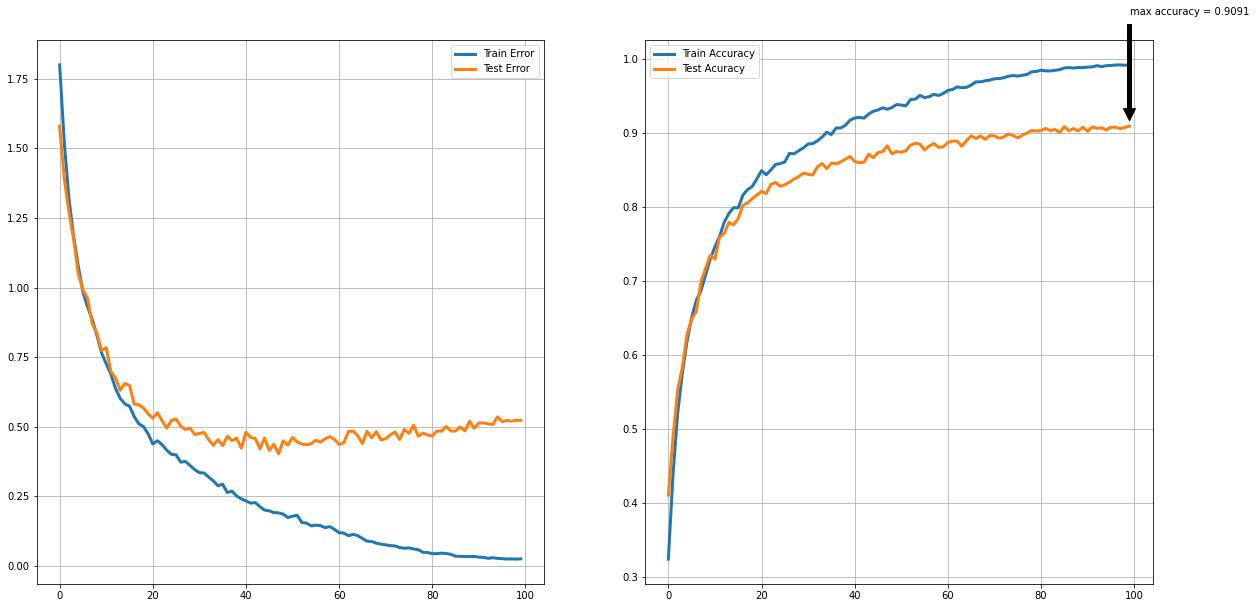

In [ ]:
from torchvision.transforms.functional import center_crop
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error')
ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy')
ax2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("3-Layer-TrainTestCurve.png")